<a href="https://colab.research.google.com/github/Joagai23/SistemasInteligentesPokerBot/blob/master/Poker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install PyPokerEngine

     |████████████████████████████████| 51kB 2.5MB/s 
  Created wheel for PyPokerEngine: filename=PyPokerEngine-1.0.1-cp36-none-any.whl size=34037 sha256=f927c09f8eea8d626e086be0054278e0b8b8336f5353635dbfb072651acbbb68
  Stored in directory: /root/.cache/pip/wheels/76/e8/1f/1fb60c7f272ecd622e92e1d7b999d5123cc44f43884457ac7c
Successfully built PyPokerEngine


In [2]:
!pip install scikit-fuzzy

     |████████████████████████████████| 1.0MB 3.4MB/s 
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-cp36-none-any.whl size=894069 sha256=d92eff0fe79b9e25f449442e9b7ca195a1a3380d461e3382542c3366fdf73265
  Stored in directory: /root/.cache/pip/wheels/b9/4e/77/da79b16f64ef1738d95486e2731eea09d73e90a72465096600
Successfully built scikit-fuzzy


In [0]:
import pypokerengine
from pypokerengine.api.game import setup_config, start_poker
import random
from pypokerengine.players import BasePokerPlayer


class FishPlayer(BasePokerPlayer):  # Do not forget to make parent class as "BasePokerPlayer"

    #  we define the logic to make an action through this method. (so this method would be the core of your AI)
    def declare_action(self, valid_actions, hole_card, round_state):
        # valid_actions format => [raise_action_info, call_action_info, fold_action_info]
        call_action_info = valid_actions[1]
        action, amount = call_action_info["action"], call_action_info["amount"]
        return action, amount   # action returned here is sent to the poker engine

    def receive_game_start_message(self, game_info):
        pass

    def receive_round_start_message(self, round_count, hole_card, seats):
        pass

    def receive_street_start_message(self, street, round_state):
        pass

    def receive_game_update_message(self, action, round_state):
        pass

    def receive_round_result_message(self, winners, hand_info, round_state):
        pass

In [0]:
config = setup_config(max_round=100, initial_stack=1000, small_blind_amount=20)
config.register_player(name="f1", algorithm=FishPlayer())
config.register_player(name="f2", algorithm=FishPlayer())
config.register_player(name="f3", algorithm=FishPlayer())
config.register_player(name="f4", algorithm=FishPlayer())
#game_result = start_poker(config, verbose=1)


In [0]:
game_result

NameError: ignored

In [0]:
#Jugador Consola

import pypokerengine.utils.visualize_utils as U

class ConsolePlayer(BasePokerPlayer):

    def declare_action(self, valid_actions, hole_card, round_state):
        print(U.visualize_declare_action(valid_actions, hole_card, round_state, self.uuid))
        action, amount = self._receive_action_from_console(valid_actions)
        return action, amount

    def receive_game_start_message(self, game_info):
        print(U.visualize_game_start(game_info, self.uuid))
        self._wait_until_input()

    def receive_round_start_message(self, round_count, hole_card, seats):
        print(U.visualize_round_start(round_count, hole_card, seats, self.uuid))
        self._wait_until_input()

    def receive_street_start_message(self, street, round_state):
        print(U.visualize_street_start(street, round_state, self.uuid))
        self._wait_until_input()

    def receive_game_update_message(self, new_action, round_state):
        print(U.visualize_game_update(new_action, round_state, self.uuid))
        self._wait_until_input()

    def receive_round_result_message(self, winners, hand_info, round_state):
        print(U.visualize_round_result(winners, hand_info, round_state, self.uuid))
        self._wait_until_input()

    def _wait_until_input(self):
        print("Enter some key to continue ...")

    # FIXME: This code would be crash if receives invalid input.
    #        So you should add error handling properly.
    def _receive_action_from_console(self, valid_actions):
        #action = raw_input("Enter action to declare >> ")
        action = 'raise' #@param ["'fold'", "'call'", "'raise'"] {type:"raw"}
        if action == 'fold': 
          amount = 0
        if action == 'call':  
          amount = valid_actions[1]['action']
        if action == 'raise':  
          amount = 5 #@param {type:"raw"}
        return action, amount

In [0]:
#Juega una partida
from pypokerengine.api.game import setup_config, start_poker

config = setup_config(max_round=10, initial_stack=100, small_blind_amount=5)
config.register_player(name="fish_player", algorithm=FishPlayer())
config.register_player(name="human_player", algorithm=ConsolePlayer())
game_result = start_poker(config, verbose=0)  # verbose=0 because game progress is visualized by ConsolePlayer

-- Game start (UUID = ocptacfbnuovyaljfqihbl) --
-- rule --
  - 2 players game
  - 10 round
  - start stack = 100
  -        ante = 0
  - small blind = 5
Enter some key to continue ...
-- Round 1 start (UUID = ocptacfbnuovyaljfqihbl) --
-- hole card --
  - ['D4', 'S6']
-- players information --
  - 0 : fish_player (zlayofvzpqdkdpgrjsfclk) => state : participating, stack : 90
  - 1 : human_player (ocptacfbnuovyaljfqihbl) => state : participating, stack : 95
Enter some key to continue ...
-- New street start (UUID = ocptacfbnuovyaljfqihbl) --
-- street --
  - preflop
Enter some key to continue ...
-- Declare your action (UUID = ocptacfbnuovyaljfqihbl) --
-- valid actions --
  - fold
  - call: 10
  - raise: [15, 100]
-- hole card --
  - ['D4', 'S6']
-- round state --
  - dealer btn : fish_player
  - street : preflop
  - community card : []
  - pot : main = 15, side = []
  - players information
    - 0 : fish_player (zlayofvzpqdkdpgrjsfclk) => state : participating, stack : 90 <= BB
    - 

In [0]:
#probabilidad de victoria
def estimate_hand_strength(nb_simulation, nb_player, hole_card, community_card):
    simulation_results = []
    for i in range(nb_simulation):
        opponents_cards = []
        for j in range(nb_player-1):  # nb_opponents = nb_player - 1
            opponents_cards.append(draw_cards_from_deck(num=2))
        nb_need_community = 5 - len(community_card)
        community_card.append(draw_cards_from_deck(num=nb_need_community))
        result = observe_game_result(hole_card, community_card, opponents_cards)  # return 1 if win else 0
        simulation_results.append(result)
    average_win_rate = 1.0 * sum(simulation_results) / len(simulation_results)
    return average_win_rate

In [0]:
#S=spares, D=Diamonds, C=Treboles, H=hearts
#EN LA PRIMERA SI HAY MAS DEL 0.4 VALE LA PENA SEGUIR
#SI BAJA FUERA, SI SUBE SE SIGUE (MAS DE 0.7)
#EN LA 3 SI HAY MAS DEL 0.9 SUBE
from pypokerengine.utils.card_utils import gen_cards, estimate_hole_card_win_rate
hole_card = gen_cards(['H3', 'HA'])
community_card = gen_cards([])
estimate_hole_card_win_rate(nb_simulation=1000, nb_player=5, hole_card=hole_card, community_card=community_card)

0.231

In [0]:
from pypokerengine.utils.card_utils import gen_cards, estimate_hole_card_win_rate
hole_card = gen_cards(['H3', 'HA'])
community_card = gen_cards(['SQ', 'H8', 'D4'])
estimate_hole_card_win_rate(nb_simulation=1000, nb_player=5, hole_card=hole_card, community_card=community_card)

0.124

In [0]:
from pypokerengine.utils.card_utils import gen_cards, estimate_hole_card_win_rate
hole_card = gen_cards(['H3', 'HA'])
community_card = gen_cards(['SQ', 'H8', 'D4', 'HK'])
estimate_hole_card_win_rate(nb_simulation=1000, nb_player=5, hole_card=hole_card, community_card=community_card)

0.258

In [0]:
from pypokerengine.utils.card_utils import gen_cards, estimate_hole_card_win_rate
hole_card = gen_cards(['H3', 'HA'])
community_card = gen_cards(['SQ', 'H8', 'D4', 'HK', 'CA'])
estimate_hole_card_win_rate(nb_simulation=1000, nb_player=5, hole_card=hole_card, community_card=community_card)

0.458

hacer dos fuzzys, uno para seguir o no seguir y otro para medir la cantidad de apuesta

Probarlo primero con los bots y depsues en la real life

In [0]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

In [0]:
#Fuzzy
#Antecedentes: ronda, porcentage, dinero
#Consecuencia:accion
#acciones->abandonar, seguir
rounds = ctrl.Antecedent(np.arange(0, 5, 1), 'Round')
percentage = ctrl.Antecedent(np.arange(0, 101, 1), 'Percentage') 
money = ctrl.Antecedent(np.arange(0, 101, 1), 'Money')

action = ctrl.Consequent(np.arange(0, 101, 1), 'Action')

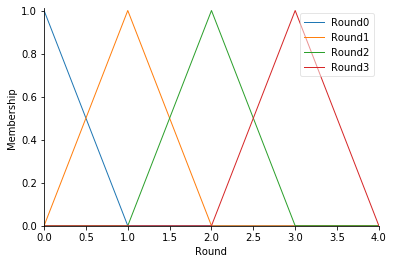

In [8]:
rounds['Round0'] = fuzz.trimf(rounds.universe, [0, 0, 1])
rounds['Round1'] = fuzz.trimf(rounds.universe, [1, 1, 2])
rounds['Round2'] = fuzz.trimf(rounds.universe, [2, 2, 3])
rounds['Round3'] = fuzz.trimf(rounds.universe, [3, 3, 4])
rounds.view()

In [0]:
#Fuzzy2
#Antecedentes: ronda, porcentage, dinero
#Consecuencia:accion
#acciones->cantidad de la apuesta
rounds = ctrl.Antecedent(np.arange(0, 5, 1), 'Round')
percentage = ctrl.Antecedent(np.arange(0, 101, 1), 'Percentage') 
money = ctrl.Antecedent(np.arange(0, 101, 1), 'Money')

action = ctrl.Consequent(np.arange(0, 101, 1), 'Action')